In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

data_len = 14400
bits = 15
import numpy as np

def generate_sine_tensor(num_bits, length):
    # Create an array of integers from 0 to length - 1
    t = np.arange(length)
    # Generate the sine waves for each bit
    sine_tensor = np.zeros((length, num_bits))  # Initialize the tensor
    
    for i in range(num_bits):
        frequency = (np.pi / (2 ** i))  # Calculate frequency based on the number of bits
        sine_tensor[:, i] = np.sin(frequency * (t+0.5))  # Fill the tensor with sine values

    return sine_tensor

# Example usage
num_bits = bits # Change this for different number of bits
length = data_len   # Change this for different lengths
result_tensor = generate_sine_tensor(num_bits, length)




In [15]:
binary_tensor = result_tensor

In [47]:
binary_tensor[-2]

array([ 1.        , -0.70710678, -0.92387953, -0.55557023, -0.29028468,
       -0.14673047,  0.07356456,  0.99932238,  0.69397146,  0.37416406,
        0.19057475, -0.09572699, -0.99885125, -0.68995705,  0.37158424])

In [16]:
def add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1):
    """
    Adds Gaussian noise to the beginning and end of the data.
    
    Parameters:
        data (numpy.ndarray): The input data to which noise will be added.
        noise_std (float): The standard deviation of the Gaussian noise.
        noise_fraction (float): The fraction of the data at the beginning and end where noise will be added.
    
    Returns:
        numpy.ndarray: Data with added Gaussian noise.
    """
    # Determine the length of the data and the size of the noise sections
    data_len = len(data)
    noise_len = int(data_len * noise_fraction)

    # Generate Gaussian noise for the beginning and end of the data
    noise_start = np.random.normal(0, noise_std, noise_len)
    noise_end = np.random.normal(0, noise_std, noise_len)

    # Create a copy of the data to modify
    noisy_data = data.copy()

    # Add noise to the beginning and end
    noisy_data[:noise_len] = noise_start
    noisy_data[-noise_len:] = noise_end

    return noisy_data


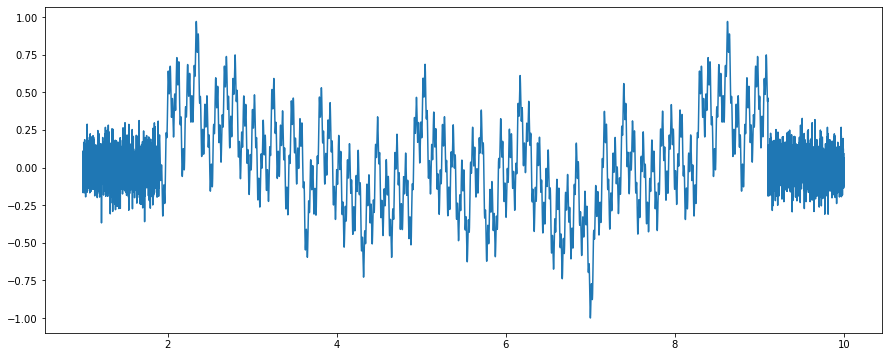

In [17]:
import numpy as np
import matplotlib.pyplot as plt
data_t = torch.from_numpy(np.linspace(1,10,data_len))


data =  (16*torch.sin(2*data_t+3)  
    + 2*torch.sin(6*data_t+1.93)  
    + 12*torch.sin(26*data_t+4.2) 
    + 16*torch.sin(21*data_t+2.43)  
    + 33*torch.sin(56*data_t+1.9)  
    + 11*torch.sin(17*data_t+24) 
    + 7.5*torch.sin(2*data_t+3)  
    + 9.4*torch.sin(6*data_t+1.93)  
    + 15.7*torch.sin(246*data_t+4.2) 
    + 17.5*torch.sin(11*data_t+2.43)  
    + 18*torch.sin(5*data_t+1.9)  
    + 25.8*torch.sin(1*data_t+24) )
data = data.detach().numpy().astype(np.float64)
max_amp = max(abs(data))
data = data/max_amp
data = add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')

Sample Rate: 24000
Data Shape: (14400,)
21397


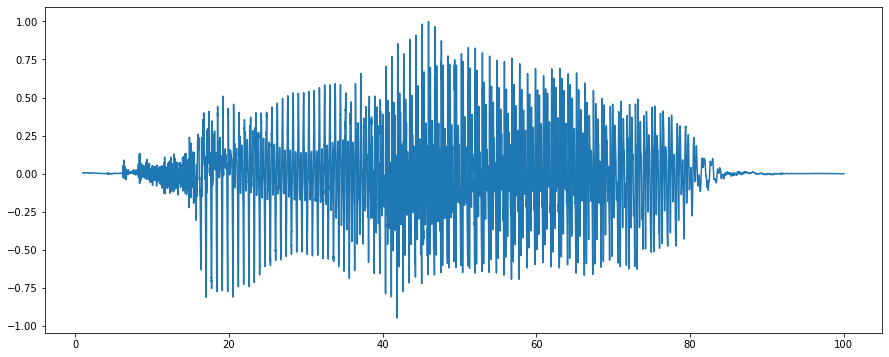

In [18]:
import numpy as np
from scipy.io import wavfile

# Load the WAV file
file_path = 'hello.wav'
sample_rate, data = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100,data.shape[0]))
max_amp = max(abs(data))
data = data/max_amp
##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')


print(max_amp)


In [19]:
data.shape

(14400,)

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomSinDataset(Dataset):
    def __init__(self, binary_tensor, data):
        self.binary_tensor = binary_tensor
        self.data = data

    def __len__(self):
        return len(self.data)  # Return the number of samples

    def __getitem__(self, idx):
        # For each sample, return the input (binary_tensor) and the corresponding prediction (data)
        return self.binary_tensor[idx], self.data[idx]

# Creating your dataset
def create_dataloader(binary_tensor, data, batch_size=32, shuffle=True):
    # Initialize dataset
    dataset = CustomSinDataset(binary_tensor, data)

    # Wrap the dataset in a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataloader

In [21]:
batch_size = 200  # Define your batch size
dataloader = create_dataloader(binary_tensor, data, batch_size=batch_size)

"""
# Loop through DataLoader
for inputs, targets in dataloader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    print(inputs, targets)
    break
"""

"\n# Loop through DataLoader\nfor inputs, targets in dataloader:\n    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')\n    print(inputs, targets)\n    break\n"

In [22]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(SimpleModel, self).__init__()
        
        # A few fully connected layers with ReLU activation
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

# Example of creating the model
input_dim = bits  # The input binary tensor has 10 bits per sample
output_dim = 1  # We are predicting a single value per input
hidden_dim = 64  # Number of units in hidden layers (you can adjust this)

model = SimpleModel(bits, output_dim, hidden_dim)

# Now the `model` is ready to be used in your training loop
print(model)

SimpleModel(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [91]:


# Assuming `model` is predefined and your dataloader is created as shown earlier

# Define the loss function (MSE Loss)
criterion = nn.MSELoss()

# Define the optimizer (e.g., Adam or SGD)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop function
def train_model(model, dataloader, num_epochs=10):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for i, (inputs, targets) in enumerate(dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())  # Ensure inputs are of type float
            
            # Compute loss
            loss = criterion(outputs.squeeze(), targets.float())  # Targets also need to be float
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        print(epoch, running_loss/data_len)
        running_loss = 0.0

    print('Finished Training')

# Example usage:
num_epochs = 100  # You can adjust the number of epochs
train_model(model, dataloader, num_epochs=num_epochs)


0 7.469112954115392e-06
1 7.332852660005705e-06
2 7.378209015263969e-06
3 7.4024848274550295e-06
4 7.250157965851637e-06
5 7.291866859304719e-06
6 7.342874402335535e-06
7 7.306979508333219e-06
8 7.247595923318941e-06
9 7.239911986592536e-06
10 7.245513358308623e-06
11 7.290620568609383e-06
12 7.273712172819715e-06
13 7.275467206555832e-06
14 7.255838928459626e-06
15 7.233626375738014e-06
16 7.216116686726714e-06
17 7.285919847264369e-06
18 7.345042354750654e-06
19 7.138386750335081e-06
20 7.170972959203128e-06
21 7.123083422710705e-06
22 7.208216427696041e-06
23 7.18581110251964e-06
24 7.191688313873278e-06
25 7.165892723908958e-06
26 7.096350196257441e-06
27 7.165993043195663e-06
28 7.283638252475713e-06
29 7.141316414668432e-06
30 7.253278421962427e-06
31 7.181846206852545e-06
32 7.199821888611445e-06
33 7.161704104671824e-06
34 7.195008305037239e-06
35 7.212743399173228e-06
36 7.105292303701087e-06
37 7.214419302828092e-06
38 7.2041740915867394e-06
39 7.103587963178547e-06
40 7.1104

In [92]:
import matplotlib.pyplot as plt
model.eval()
eval_dataloader = create_dataloader(binary_tensor, data, batch_size=batch_size, shuffle=False)

def run_inference(model, dataloader):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    predictions = []
    true_values = []
    
    with torch.no_grad():  # No need to compute gradients for inference
        for inputs, targets in dataloader:
            outputs = model(inputs.float())  # Forward pass through the model
            predictions.extend(outputs.numpy())  # Store predictions
            true_values.extend(targets.numpy())  # Store true values
    
    return predictions, true_values

# Example: Run inference on the trained model
predictions, true_values = run_inference(model, eval_dataloader)


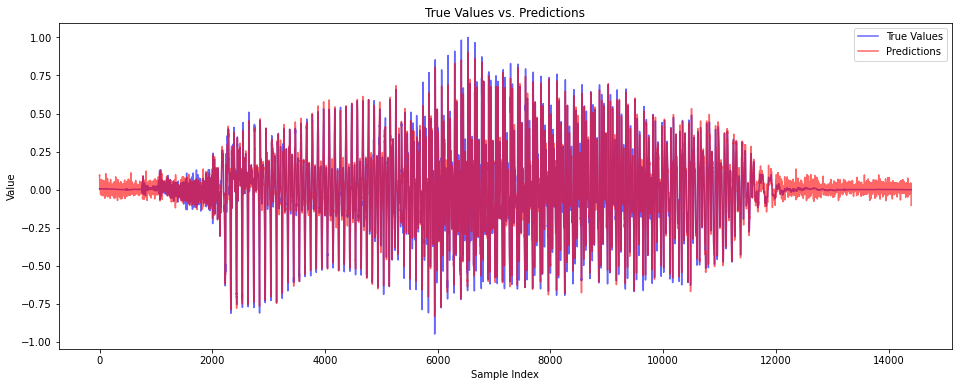

In [93]:
# Convert the predictions and true values to numpy arrays for easier plotting
predictions = np.array(predictions).flatten()  # Flatten in case outputs are multi-dimensional
true_values = np.array(true_values).flatten()

# Plotting the true values vs. predicted values
plt.figure(figsize=(16,6))
plt.plot(true_values, label='True Values', color='blue', alpha=0.6)
plt.plot(predictions, label='Predictions', color='red', alpha=0.6)
plt.legend()
plt.title('True Values vs. Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


In [94]:
import torch
import numpy as np
from scipy.io.wavfile import write

def tensor_to_wav(tensor, filename, sample_rate=44100, max_amp=1):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data*max_amp)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(torch.tensor(predictions), "first_try.wav", sample_rate=sample_rate,max_amp = max_amp )


Saved as first_try.wav


In [95]:
from IPython.display import Audio

# Play the .wav file
Audio("hello.wav")


In [96]:
Audio("first_try.wav")

Sample Rate: 24000
Data Shape: (14400,)
19288


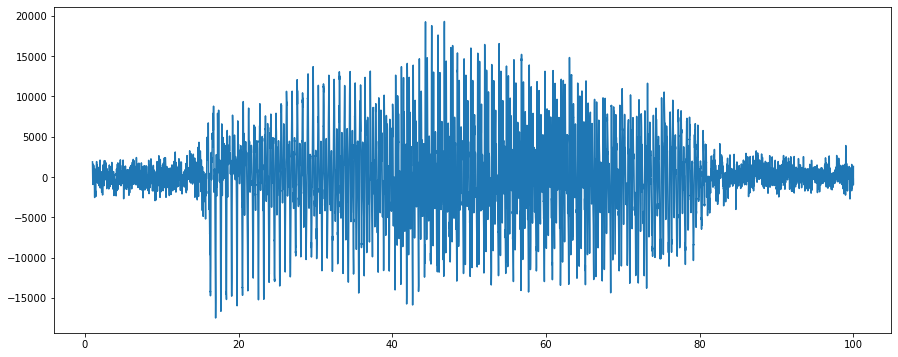

In [276]:
file_path = 'first_try.wav'
sample_rate, data_test = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100,data.shape[0]))

##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data_test, label='Layer Output')


print(max_amp)


In [39]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
total_params = count_parameters(model)
print(f"Total number of trainable parameters: {total_params}")


Total number of trainable parameters: 5249


In [ ]:
also, this is for sure using less of the t than needed, like, some of the higher bits are always -1.  

In [277]:
torch.save(model.state_dict(), "first_try_model_weights.pth")

In [278]:
torch.save(model, "first_try_model.pth")